In [123]:
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy.stats import gamma, invgauss
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

# Load data

In [16]:

# create connection to sqlite db file
conn = create_engine("sqlite:///../db/test.db")


# load data from sqlite
df = pd.read_sql(
    sql="original_data", #  table name
    con=conn,
    index_col="Row_ID"
)

In [17]:
df.head()

,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,Cat3,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
Row_ID,,,,,,,,,,,,,,,,,,,,,
10435088,6459234,4,2007,1998,G,G.8,G.8.3,F,?,A,...,-0.965540,-1.004587,-1.439141,-0.918689,N,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2560445,1875568,1,2007,2004,BZ,BZ.11,BZ.11.2,B,A,A,...,-0.828755,-1.036169,-0.714171,-0.941224,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
5865974,4010054,4,2006,2003,Y,Y.42,Y.42.2,F,C,A,...,0.402303,-0.288724,-0.923061,-0.197237,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1617366,922766,3,2006,1983,BW,BW.49,BW.49.1,H,?,C,...,-0.769284,0.182669,2.050541,-1.439512,N,-0.23153,-0.266117,2.715490,-0.251419,0.0
9914424,6289123,5,2005,1999,BW,BW.166,BW.166.0,I,C,A,...,0.503405,1.427241,0.932369,0.907092,M,-0.23153,-0.266117,4.209404,-0.251419,0.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 10435088 to 5538741
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Household_ID    100000 non-null  int64  
 1   Vehicle         100000 non-null  int64  
 2   Calendar_Year   100000 non-null  int64  
 3   Model_Year      100000 non-null  int64  
 4   Blind_Make      100000 non-null  object 
 5   Blind_Model     100000 non-null  object 
 6   Blind_Submodel  100000 non-null  object 
 7   Cat1            100000 non-null  object 
 8   Cat2            100000 non-null  object 
 9   Cat3            100000 non-null  object 
 10  Cat4            100000 non-null  object 
 11  Cat5            100000 non-null  object 
 12  Cat6            100000 non-null  object 
 13  Cat7            100000 non-null  object 
 14  Cat8            100000 non-null  object 
 15  Cat9            100000 non-null  object 
 16  Cat10           100000 non-null  object 
 17  Ca

## Value counts

In [51]:
# value counts for OBJECTS
for col in df.columns[df.dtypes == 'object']:
    print("-------------\n")
    print(f"`{col}` value counts")
    print(df[col].value_counts(dropna=False))
    print("\n")

-------------

`Blind_Make` value counts
K     12510
AJ    11696
BW     9807
AU     8170
Y      6529
      ...  
AT        1
BK        1
B         1
H         1
BS        1
Name: Blind_Make, Length: 64, dtype: int64


-------------

`Blind_Model` value counts
K.7       4544
AU.14     2299
X.45      2162
W.16      1794
AU.11     1526
          ... 
AY.2         1
BG.17        1
AJ.106       1
BO.99        1
BB.1         1
Name: Blind_Model, Length: 1000, dtype: int64


-------------

`Blind_Submodel` value counts
K.7.3      1268
AU.58.0    1157
AU.14.1    1079
W.16.3     1061
AU.14.0    1042
           ... 
BU.8.0        1
R.22.9        1
AU.36.1       1
AZ.39.1       1
BT.46.2       1
Name: Blind_Submodel, Length: 2004, dtype: int64


-------------

`Cat1` value counts
B    30230
I    20384
D    18886
F     9967
G     5848
A     5845
C     2968
E     2167
H     1757
J     1739
?      209
Name: Cat1, dtype: int64


-------------

`Cat2` value counts
C    44736
?    36796
A    16816
B   

In [52]:
# value counts for INT cols
for col in df.columns[df.dtypes == "int64"]:
    print("---------\n")
    print(f"`{col}` value counts")
    print(df[col].value_counts(dropna=False))
    print("\n")

---------

`Household_ID` value counts
6398912    3
4784923    3
6405962    3
4970280    3
6650234    3
          ..
6335423    1
7164864    1
7429057    1
4410307    1
2097152    1
Name: Household_ID, Length: 98603, dtype: int64


---------

`Vehicle` value counts
1     48271
2     29222
3     13300
4      5511
5      2182
6       874
7       359
8       150
9        81
10       22
12       12
11        9
18        2
13        2
14        1
17        1
22        1
Name: Vehicle, dtype: int64


---------

`Calendar_Year` value counts
2007    35368
2006    34007
2005    30625
Name: Calendar_Year, dtype: int64


---------

`Model_Year` value counts
2004    8124
2002    8084
2003    7730
2005    7678
2000    7624
2001    7516
1999    6726
1998    6055
1997    5551
2006    5400
1995    4672
1996    4580
1994    3564
1993    2862
2007    2731
1992    2095
1991    1816
1990    1485
1989    1336
1988    1006
1987     807
1986     692
1985     508
1984     412
2008     342
1983     260
1982   

## Descriptive statistics

In [39]:
# descriptive statistics for FLOATS
for col in df.columns[df.dtypes == 'float64']:
    print("-------------")
    print(f"`{col}` descriptive statistics")
    print(df[col].describe())

-------------
`Var1` descriptive statistics
count    100000.000000
mean         -0.008068
std           0.983619
min          -2.578222
25%          -0.665897
50%          -0.320393
75%           0.442930
max           4.540768
Name: Var1, dtype: float64
-------------
`Var2` descriptive statistics
count    100000.000000
mean         -0.062719
std           0.970508
min          -2.493393
25%          -0.816152
50%          -0.124506
75%           0.480684
max           7.206938
Name: Var2, dtype: float64
-------------
`Var3` descriptive statistics
count    100000.000000
mean         -0.025433
std           1.020209
min          -2.744055
25%          -0.869687
50%          -0.221758
75%           0.726996
max           5.563325
Name: Var3, dtype: float64
-------------
`Var4` descriptive statistics
count    100000.000000
mean         -0.052288
std           0.970138
min          -2.508216
25%          -0.783019
50%          -0.106471
75%           0.485509
max           6.980369
Name: V

## Duplicates

In [42]:
print(f"There are {len(df.drop_duplicates())} unique rows out of {len(df)} total rows in dataset")

There are 100000 unique rows out of 100000 total rows in dataset


In [50]:
# multiple occurence of households in dataset
household_occurence_counts = df.groupby("Household_ID")["Household_ID"].count()

print(household_occurence_counts[household_occurence_counts>1].describe())

count    1374.000000
mean        2.016739
std         0.128340
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: Household_ID, dtype: float64


Certain households appear in dataset multiple times, maximum 3 times.

## Missing values  

Some categorical variables contain `?` as category name, will have to revise if NaN should be replaced there.

## Helper features

In [114]:
# just adding a separate column which indicates if insurance claim was positive

df["Claim_Positive"] = df.Claim_Amount.apply(lambda x: True if x > 0 else False)

## Plots

/Users/rok-mi/my_projects/ektimo-test/venv/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


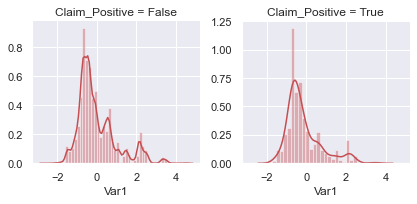

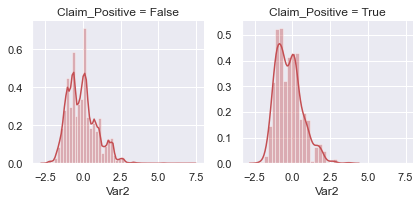

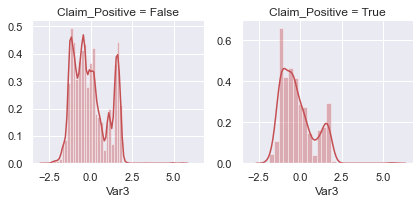

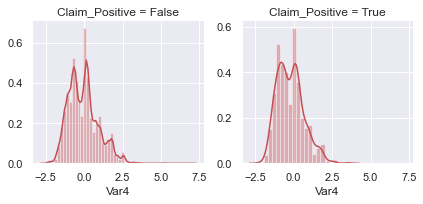

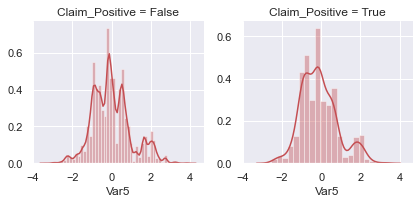

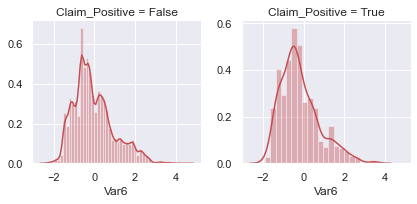

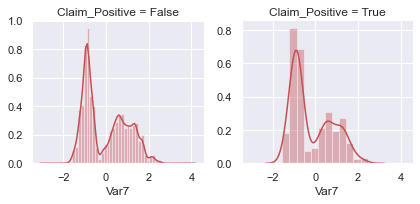

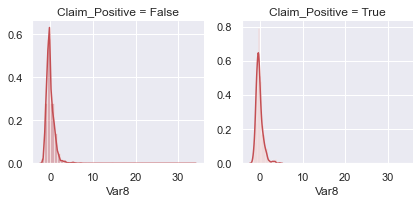

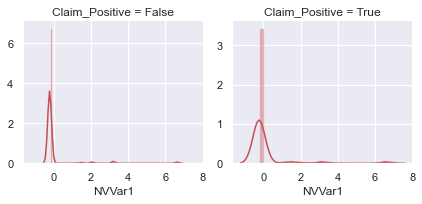

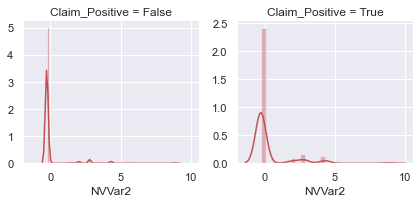

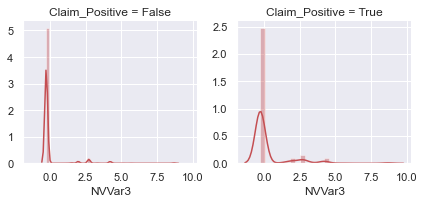

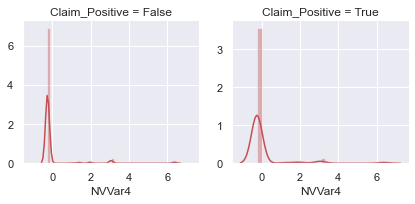

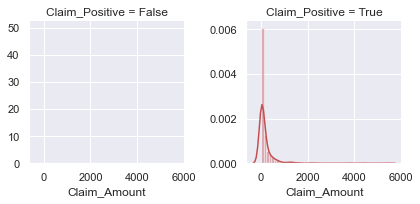

In [115]:
# We will plot distribution of continuous variables across non-zero and zero claims

# selecting variables
continuous_variables_cols = df.columns[df.dtypes == 'float64']


for i, col in enumerate(continuous_variables_cols):
    d = df[col]
        
    g = sns.FacetGrid(df, col="Claim_Positive", sharey=False)
    g = g.map(sns.distplot, col, kde=True, color="r")

### Distribution

Lets check if the claims follow an inverted gauss distribution

Gamma fit


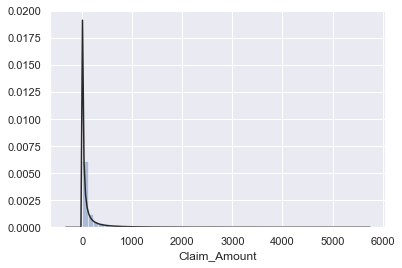

In [155]:
print("Gamma fit")
sns.distplot(df_with_claims["Claim_Amount"], fit=invgauss, kde=False)